In [23]:
import numpy as np
import networkx as nx
import pylab as plt
from scipy.stats import norm,uniform,binom,poisson
import random
from functools import reduce
from itertools import product
from collections import deque
import re
from time import sleep
import json
import copy
import unicodedata

In [24]:
with open('raw_metro_data.json', 'r') as fp: 
    line_dict = json.load(fp)
    line_dict = {int(key): value for key, value in line_dict.items()}


In [25]:
line_dict = {
    1: line_dict[1][0],
    2: line_dict[2][0],
    3: line_dict[3][0],
    4: line_dict[4][1],
    5: line_dict[5][1],
    6: line_dict[6][0],
    7: line_dict[7][1],
    8: line_dict[8][1],
    9: line_dict[9][1],
    10: line_dict[10][0],
}
dict_copy = copy.deepcopy(line_dict)

### End Stations

In [26]:
for key,val in dict_copy.items():
    c = []
    for k in val:
        if k[0] == k[1]:
            continue
        elif bool(re.search(r'nea (\d+)',k[0])):
            continue
        else:
            c.append(k[0].replace(' ','_'))
    dict_copy[key] = c

end_nodes = {}
for key,val in dict_copy.items():
    end_nodes[key] = [val[0],val[-1]]

with open('end_stations.json', 'w') as fp: # write clean file
    json.dump(end_nodes,fp)

### ALL STATIONS

In [27]:
for key,val in line_dict.items():
    c = []
    for i in val:
        if i[0] == i[1]:
            continue
        elif i[1]:
            c.append([i[1],[]])
        
        else:
            try:
                linea = re.search(r'nea (\d+)',i[0]).group(1)
                if linea == str(key):
                    continue
                c[-1][1].append(int(linea))
            except:
                continue
            
    line_dict[key] = c

In [28]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    encoding = "utf-8"
    return only_ascii.decode(encoding)

for key,val in line_dict.items():
    for i in range(len(val)):
        val[i][0] = remove_accents(val[i][0].lower())

In [29]:
with open('clean_metro_data.json', 'w') as fp: # write clean file
    json.dump(line_dict,fp)

### Cleaning End Station Coordinates

In [30]:
with open('End_Stations_Coordinates_Dirty.json', 'r') as fp: # Load path for top 10 song data for each artist in our dataset
    coords = json.load(fp)

In [31]:
coords = { remove_accents(k.lower())[12:].replace('_',' ') :v for k,v in coords.items()}

In [32]:
split_coords = {}
for keys,vals in coords.items():
    x = re.search(r'(\d+°\d+′\d+).*(\d+°\d+′\d+)',vals)
    split_coords[keys] = ([re.split('[°′]',x.group(1)),re.split('[°′]',x.group(2))])
for key,val in split_coords.items():
    split_coords[key] = [float(val[0][0]) + float(val[0][1])/60 + float(val[0][2])/3600,-(float(val[1][0]) + float(val[1][1])/60 + float(val[1][2])/3600)]

In [33]:
split_coords

{'pinar de chamartin': [40.48027777777778, -3.6666666666666665],
 'valdecarros': [40.36, -3.593055555555556],
 'las rosas': [40.42388888888889, -3.6036111111111113],
 'cuatro caminos': [40.44694444444444, -3.7038888888888892],
 'moncloa': [40.43444444444444, -3.7194444444444446],
 'villaverde alto': [40.34138888888889, -3.711388888888889],
 'arguelles': [40.43055555555555, -3.716388888888889],
 'casa de campo': [40.403055555555554, -3.761111111111111],
 'alameda de osuna': [40.4575, -3.5880555555555556],
 'laguna': [40.399166666666666, -3.7444444444444445],
 'carpetana': [40.3925, -3.741388888888889],
 'pitis': [40.495, -3.7266666666666666],
 'hospital del henares': [40.4175, -3.5344444444444445],
 'aeropuerto t4': [40.49138888888889, -3.5941666666666667],
 'nuevos ministerios': [40.44638888888888, -3.6919444444444447],
 'paco de lucia': [40.499722222222225, -3.7097222222222226],
 'arganda del rey': [40.30361111111111, -3.4475000000000002],
 'puerta del sur': [40.34527777777778, -3.812

In [34]:
def convert_to_grid(lat,lon,grid_size):
    x = (lon*np.pi/180 + 180) * (grid_size / 360)
    y = (grid_size / np.pi) * np.log(np.tan(np.pi/4 + lat*np.pi/360))
    return [x,y]

In [35]:
end_coords_grid = {k : convert_to_grid(v[0],v[1],100) for k,v in split_coords.items()}

In [36]:
end_coords_grid

{'pinar de chamartin': [49.98222349835932, 24.63371335664806],
 'valdecarros': [49.98258037509681, 24.545942306783072],
 'las rosas': [49.982529200319355, 24.592544802153203],
 'cuatro caminos': [49.98204303993357, 24.60937309086584],
 'moncloa': [49.98196762447206, 24.600248603728325],
 'villaverde alto': [49.98200667890749, 24.532375105903586],
 'arguelles': [49.98198243822343, 24.597410220364402],
 'casa de campo': [49.98176561877161, 24.577343477350173],
 'alameda de osuna': [49.982604615780865, 24.617079534977655],
 'laguna': [49.98184642105179, 24.5745064178545],
 'carpetana': [49.981861234803155, 24.569643268530236],
 'pitis': [49.98193261015066, 24.64446748821016],
 'hospital del henares': [49.98286452978212, 24.587882562171476],
 'aeropuerto t4': [49.982574988278124, 24.64182946398975],
 'nuevos ministerios': [49.982100948234375, 24.60896752207378],
 'paco de lucia': [49.98201475913551, 24.64791742642667],
 'arganda del rey': [49.98328604834375, 24.504847217355234],
 'puerta d

In [37]:
import pandas as pd
x = pd.DataFrame(end_coords_grid).T
lon_max, lon_min = x[0].max(), x[0].min()
lat_max, lat_min = x[1].max(), x[1].min()
lon_diff,lat_diff = lon_max-lon_min,lat_max-lat_min

In [38]:
end_coords_normalize = {}
for key,val in end_coords_grid.items():
    end_coords_normalize[key] = [100*(val[0]-lon_min)/lon_diff,100*(val[1]-lat_min)/lat_diff]

In [39]:
with open('end_stations_coordinates_clean.json', 'w') as fp: # write clean file
    json.dump(end_coords_normalize,fp)

In [40]:
y = pd.DataFrame(end_coords_normalize).T

<Axes: xlabel='0', ylabel='1'>

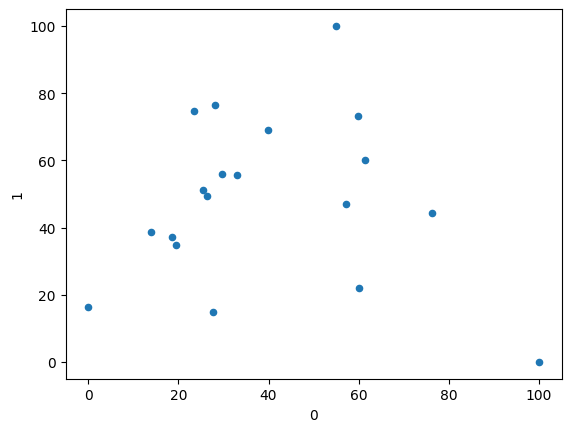

In [41]:
y.plot.scatter(x=0,y=1)